# Test constraints

**Context:** The durations for which fields are observable often jump from one day to the next. Oddly, this only happens during rise and plateauing phase, but not during setting. In this notebook I am trying to understand why this is the case.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.coordinates import AltAz, Angle, EarthLocation, get_sun, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import constraints as c
from fieldgrid import FieldGrid, FieldGridIsoLat
from surveyplanner import Field, ObsWindow, Telescope, SurveyPlanner

## Setup

### Create test grid

I copy the Northern test grid from `Develop_SurveyPlanner.ipynb`:

In [3]:
# north:
fov = np.radians(5.)
overlap_ns = fov / 2.
overlap_ew = np.radians(1.)
tilt = np.radians(0.)
gal_lat_lim = np.radians(30.)
dec_lim_south = -fov / 2.

fields_north = FieldGridIsoLat(
        fov, overlap_ns=overlap_ns, overlap_ew=overlap_ew, tilt=tilt, gal_lat_lim=gal_lat_lim, dec_lim_south=dec_lim_south)
print('\n', fields_north)

Create fields..
    Done                                                    
Final number of fields: 1056

 FieldGridIsoLat : Iso-latitudinal field grid
Field of view:     5.0000 deg
Overlap N-S        2.5000 deg
Overlap E-W        1.0000 deg
Tilt:             +0.0000 deg
Gal. lat. lim:    30.0000 deg
Dec. lim. N:      90.0000 deg
Dec. lim. S:      -2.5000 deg
Number of fields: 1056


### Select field

In [4]:
field_id = 400
#field_id = 167
field_coord = SkyCoord(fields_north.center_ras[field_id], fields_north.center_decs[field_id], unit='rad')

### Create telescope

In [5]:
name = 'Skinakas'
lat = Angle('35:12:43 deg')
lon = Angle('24:53:57 deg')
height = 1750.
utc_offset = 2.
telescope = Telescope(lat, lon, height, utc_offset, name=name)

Telescope Skinakas created.


### Helper function(s)

To identify blocks I use this function that I copied from `surveyplanner.Field._true_blocks()`:

In [6]:
def true_blocks(observable):
    """Find blocks of successive True's.

    Parameters
    ----------
    observable : nump.ndarray
        Boolean-type 1dim-array.

    Returns
    -------
    list
        Each element corresponds to one block of True's. The element is a
        list of two integers, the first marking the first index of the
        block, the second marking the last True entry of the block.
    """

    i = 0
    periods = []

    # iterate through array:
    while i < observable.size-1:
        if ~np.any(observable[i:]):
            break
        j = np.argmax(observable[i:]) + i
        k = np.argmax(~observable[j:]) + j
        if j == k and j != observable.size-1:
            k = observable.size
        periods.append((j,k-1))
        i = k

    return periods

### Set time range

In [7]:
date_start = Time('2024-01-01')
date_stop = Time('2024-04-01')
twilight = 'nautical'

## Test 1: effect of sampling time interval

### Set constraints

I use the constraints for the Northern survey. For simplicity I only use the airmass limit:

In [8]:
twilight = 'nautical'
airmass_limit = c.AirmassLimit(2.)
hourangle_limit = c.HourangleLimit(5.33)
moon_distance = c.MoonDistance(10.)
constraints = c.Constraints()
constraints.add(airmass_limit)
#constraints.add(hourangle_limit)
#constraints.add(moon_distance)

### Run with different time samplings

In [9]:
jds = np.arange(date_start.jd, date_stop.jd)
obswindow_start = []
obswindow_stop = []
duration = []
sampling = []

In [10]:
time_sampling = 15 # minutes

for i, date in enumerate(jds):
    print(f'\rProgress: {i/jds.size*100:.1f}%..', end='')
    
    dt = Time(date, format='jd').datetime
    time_sunset, time_sunrise = telescope.get_sun_set_rise(dt.year, dt.month, dt.day, twilight)
    frame = telescope.get_frame(time_sunset, time_sunrise, time_sampling*u.min)
    observable = constraints.get(field_coord, frame)
    blocks = true_blocks(observable)
    
    for block_id0, block_id1 in blocks:
        obswindow_start.append(frame.obstime[block_id0].jd)
        obswindow_stop.append(frame.obstime[block_id1].jd)
        duration.append(frame.obstime[block_id1].jd-frame.obstime[block_id0].jd)
        sampling.append(time_sampling)
    
    if not len(blocks):
        obswindow_start.append(np.nan)
        obswindow_stop.append(np.nan)
        duration.append(0)
        sampling.append(time_sampling)

print('\rProgress: done.        ')

Progress: done.        


In [11]:
time_sampling = 10 # minutes

for i, date in enumerate(jds):
    print(f'\rProgress: {i/jds.size*100:.1f}%..', end='')
    
    dt = Time(date, format='jd').datetime
    time_sunset, time_sunrise = telescope.get_sun_set_rise(dt.year, dt.month, dt.day, twilight)
    frame = telescope.get_frame(time_sunset, time_sunrise, time_sampling*u.min)
    observable = constraints.get(field_coord, frame)
    blocks = true_blocks(observable)
    
    for block_id0, block_id1 in blocks:
        obswindow_start.append(frame.obstime[block_id0].jd)
        obswindow_stop.append(frame.obstime[block_id1].jd)
        duration.append(frame.obstime[block_id1].jd-frame.obstime[block_id0].jd)
        sampling.append(time_sampling)
    
    if not len(blocks):
        obswindow_start.append(np.nan)
        obswindow_stop.append(np.nan)
        duration.append(0)
        sampling.append(time_sampling)

print('\rProgress: done.        ')

Progress: done.        


In [12]:
time_sampling = 5 # minutes

for i, date in enumerate(jds):
    print(f'\rProgress: {i/jds.size*100:.1f}%..', end='')
    
    dt = Time(date, format='jd').datetime
    time_sunset, time_sunrise = telescope.get_sun_set_rise(dt.year, dt.month, dt.day, twilight)
    frame = telescope.get_frame(time_sunset, time_sunrise, time_sampling*u.min)
    observable = constraints.get(field_coord, frame)
    blocks = true_blocks(observable)
    
    for block_id0, block_id1 in blocks:
        obswindow_start.append(frame.obstime[block_id0].jd)
        obswindow_stop.append(frame.obstime[block_id1].jd)
        duration.append(frame.obstime[block_id1].jd-frame.obstime[block_id0].jd)
        sampling.append(time_sampling)
    
    if not len(blocks):
        obswindow_start.append(np.nan)
        obswindow_stop.append(np.nan)
        duration.append(0)
        sampling.append(time_sampling)

print('\rProgress: done.        ')

Progress: done.        


In [13]:
time_sampling = 2 # minutes

for i, date in enumerate(jds):
    print(f'\rProgress: {i/jds.size*100:.1f}%..', end='')
    
    dt = Time(date, format='jd').datetime
    time_sunset, time_sunrise = telescope.get_sun_set_rise(dt.year, dt.month, dt.day, twilight)
    frame = telescope.get_frame(time_sunset, time_sunrise, time_sampling*u.min)
    observable = constraints.get(field_coord, frame)
    blocks = true_blocks(observable)
    
    for block_id0, block_id1 in blocks:
        obswindow_start.append(frame.obstime[block_id0].jd)
        obswindow_stop.append(frame.obstime[block_id1].jd)
        duration.append(frame.obstime[block_id1].jd-frame.obstime[block_id0].jd)
        sampling.append(time_sampling)
    
    if not len(blocks):
        obswindow_start.append(np.nan)
        obswindow_stop.append(np.nan)
        duration.append(0)
        sampling.append(time_sampling)

print('\rProgress: done.        ')

Progress: done.        


In [14]:
time_sampling = 1 # minutes

for i, date in enumerate(jds):
    print(f'\rProgress: {i/jds.size*100:.1f}%..', end='')
    
    dt = Time(date, format='jd').datetime
    time_sunset, time_sunrise = telescope.get_sun_set_rise(dt.year, dt.month, dt.day, twilight)
    frame = telescope.get_frame(time_sunset, time_sunrise, time_sampling*u.min)
    observable = constraints.get(field_coord, frame)
    blocks = true_blocks(observable)
    
    for block_id0, block_id1 in blocks:
        obswindow_start.append(frame.obstime[block_id0].jd)
        obswindow_stop.append(frame.obstime[block_id1].jd)
        duration.append(frame.obstime[block_id1].jd-frame.obstime[block_id0].jd)
        sampling.append(time_sampling)
    
    if not len(blocks):
        obswindow_start.append(np.nan)
        obswindow_stop.append(np.nan)
        duration.append(0)
        sampling.append(time_sampling)

print('\rProgress: done.        ')

Progress: done.        


In [15]:
obswindow_start = np.array(obswindow_start)
obswindow_stop = np.array(obswindow_stop)
duration = np.array(duration)
sampling = np.array(sampling)
jds = np.tile(jds, duration.shape[0]//jds.shape[0])
obswindows = pd.DataFrame({
        'sampling': sampling, 'jd': jds, 'start': obswindow_start, 'stop': obswindow_stop, 
        'start_hour': (obswindow_start - jds) * 24, 'stop_hour': (obswindow_stop - jds) * 24,
        'duration': duration})
del obswindow_start, obswindow_stop, duration, jds, sampling

#### Comparision of results

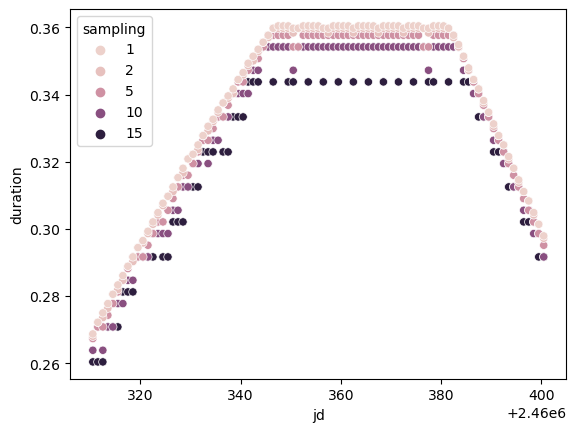

In [16]:
sns.scatterplot(data=obswindows, x='jd', y='duration', hue='sampling');

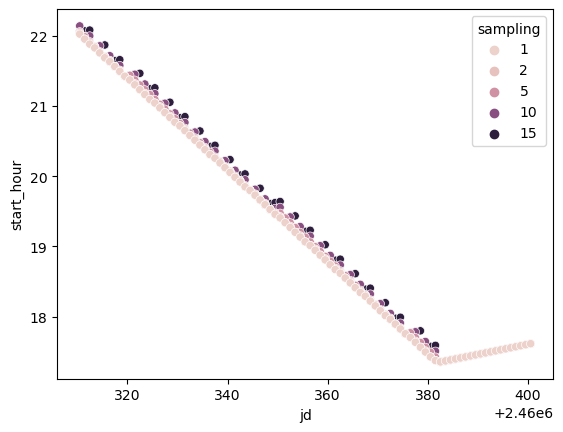

In [17]:
sns.scatterplot(data=obswindows, x='jd', y='start_hour', hue='sampling');

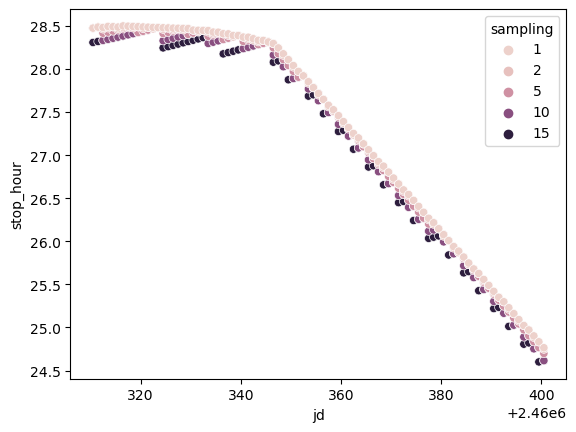

In [18]:
sns.scatterplot(data=obswindows, x='jd', y='stop_hour', hue='sampling');

#### Details of a single sampling selection

In [19]:
sampling = 1

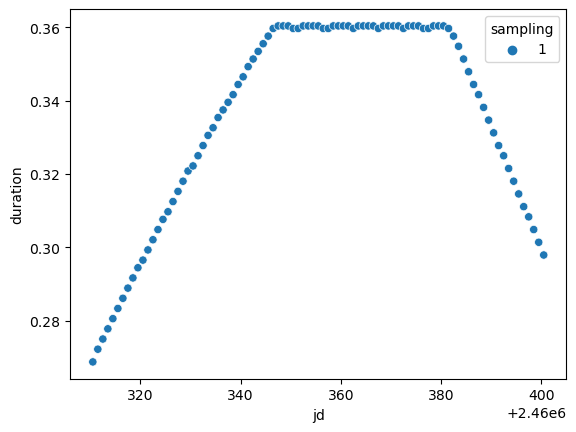

In [20]:
sel = obswindows['sampling'] == sampling
sns.scatterplot(data=obswindows.loc[sel], x='jd', y='duration', hue='sampling');

Focus on the *plateauing* phase:

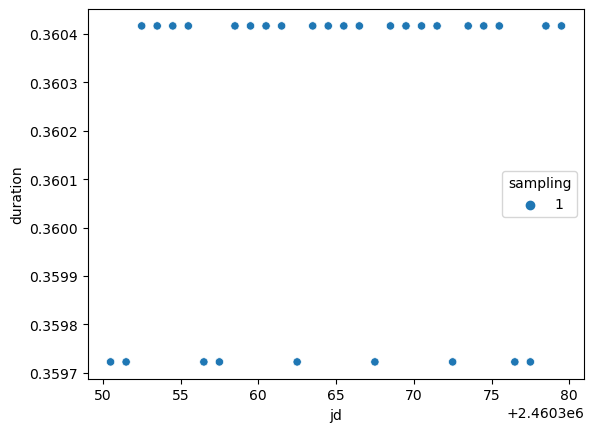

In [21]:
sel = np.logical_and.reduce([obswindows['sampling'] == sampling, obswindows['jd'] > 2460350, obswindows['jd'] < 2460380])
sns.scatterplot(data=obswindows.loc[sel], x='jd', y='duration', hue='sampling');

What are the differences between adjacent durations in the plateauing phase:

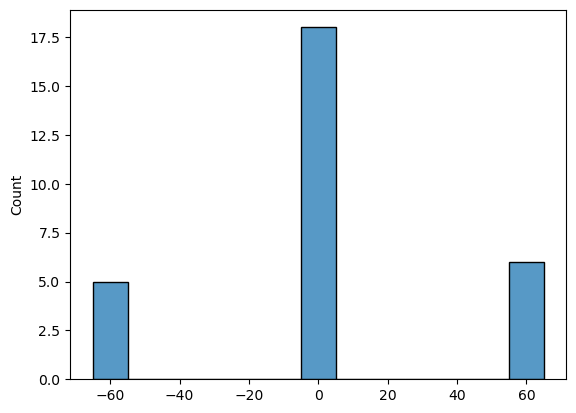

In [22]:
sns.histplot(x=np.diff(obswindows.loc[sel, 'duration'])*24*3600, binrange=(-60*sampling-5, 60*sampling+5), binwidth=10);

### Results

All jumps are within the sampling accuracy and, thus, an artifact of the sampling accuracy.

We primarily see jumps in the rising, some in the plateauing, and none in the setting phase for the following reason. Rising means that the start time is becoming earlier every day. The stop time is almost constant. However, the estimated stop time strongly affected by the sampling. This results in the jumps during the rising phase. During the plateauing phase the start time keeps becoming earlier, the stop time gradually also becomes earlier. The sampling effect is not that strong when both times change more strongly. During the setting phase both times are moving and, thus, are not strongly affected by jumps.

## Test 2: effect of the different constraints

In [23]:
time_sampling = 5 # minutes

In [24]:
jds = np.arange(date_start.jd, date_stop.jd)
obswindow_start = []
obswindow_stop = []
duration = []
labels = []

Airmass limit only:

In [25]:
twilight = 'nautical'
airmass_limit = c.AirmassLimit(2.)
hourangle_limit = c.HourangleLimit(5.33)
moon_distance = c.MoonDistance(10.)
constraints = c.Constraints()
constraints.add(airmass_limit)
#constraints.add(hourangle_limit)
#constraints.add(moon_distance)
label = 'AM'

In [26]:
for i, date in enumerate(jds):
    print(f'\rProgress: {i/jds.size*100:.1f}%..', end='')
    
    dt = Time(date, format='jd').datetime
    time_sunset, time_sunrise = telescope.get_sun_set_rise(dt.year, dt.month, dt.day, twilight)
    frame = telescope.get_frame(time_sunset, time_sunrise, time_sampling*u.min)
    observable = constraints.get(field_coord, frame)
    blocks = true_blocks(observable)
    
    for block_id0, block_id1 in blocks:
        obswindow_start.append(frame.obstime[block_id0].jd)
        obswindow_stop.append(frame.obstime[block_id1].jd)
        duration.append(frame.obstime[block_id1].jd-frame.obstime[block_id0].jd)
        labels.append(label)
    
    if not len(blocks):
        obswindow_start.append(np.nan)
        obswindow_stop.append(np.nan)
        duration.append(0)
        labels.append(label)

print('\rProgress: done.        ')

Progress: done.        


Airmass limit plus hourangle limit:

In [27]:
twilight = 'nautical'
airmass_limit = c.AirmassLimit(2.)
hourangle_limit = c.HourangleLimit(5.33)
moon_distance = c.MoonDistance(10.)
constraints = c.Constraints()
constraints.add(airmass_limit)
constraints.add(hourangle_limit)
#constraints.add(moon_distance)
label = 'AM+HA'

In [28]:
for i, date in enumerate(jds):
    print(f'\rProgress: {i/jds.size*100:.1f}%..', end='')
    
    dt = Time(date, format='jd').datetime
    time_sunset, time_sunrise = telescope.get_sun_set_rise(dt.year, dt.month, dt.day, twilight)
    frame = telescope.get_frame(time_sunset, time_sunrise, time_sampling*u.min)
    observable = constraints.get(field_coord, frame)
    blocks = true_blocks(observable)
    
    for block_id0, block_id1 in blocks:
        obswindow_start.append(frame.obstime[block_id0].jd)
        obswindow_stop.append(frame.obstime[block_id1].jd)
        duration.append(frame.obstime[block_id1].jd-frame.obstime[block_id0].jd)
        labels.append(label)
    
    if not len(blocks):
        obswindow_start.append(np.nan)
        obswindow_stop.append(np.nan)
        duration.append(0)
        labels.append(label)

print('\rProgress: done.        ')

Progress: done.        


Airmass limit plus hourangle limit + Moon distance limit:

In [29]:
twilight = 'nautical'
airmass_limit = c.AirmassLimit(2.)
hourangle_limit = c.HourangleLimit(5.33)
moon_distance = c.MoonDistance(10.)
constraints = c.Constraints()
constraints.add(airmass_limit)
constraints.add(hourangle_limit)
constraints.add(moon_distance)
label = 'AM+HA+MD'

In [30]:
for i, date in enumerate(jds):
    print(f'\rProgress: {i/jds.size*100:.1f}%..', end='')
    
    dt = Time(date, format='jd').datetime
    time_sunset, time_sunrise = telescope.get_sun_set_rise(dt.year, dt.month, dt.day, twilight)
    frame = telescope.get_frame(time_sunset, time_sunrise, time_sampling*u.min)
    observable = constraints.get(field_coord, frame)
    blocks = true_blocks(observable)
    
    for block_id0, block_id1 in blocks:
        obswindow_start.append(frame.obstime[block_id0].jd)
        obswindow_stop.append(frame.obstime[block_id1].jd)
        duration.append(frame.obstime[block_id1].jd-frame.obstime[block_id0].jd)
        labels.append(label)
    
    if not len(blocks):
        obswindow_start.append(np.nan)
        obswindow_stop.append(np.nan)
        duration.append(0)
        labels.append(label)

print('\rProgress: done.        ')

Progress: done.        


In [31]:
obswindow_start = np.array(obswindow_start)
obswindow_stop = np.array(obswindow_stop)
duration = np.array(duration)
sampling = np.array(sampling)
jds = np.tile(jds, duration.shape[0]//jds.shape[0])
obswindows = pd.DataFrame({
        'constraints': labels, 'jd': jds, 'start': obswindow_start, 'stop': obswindow_stop, 
        'start_hour': (obswindow_start - jds) * 24, 'stop_hour': (obswindow_stop - jds) * 24,
        'duration': duration})
del obswindow_start, obswindow_stop, duration, jds, labels

### Comparision of results

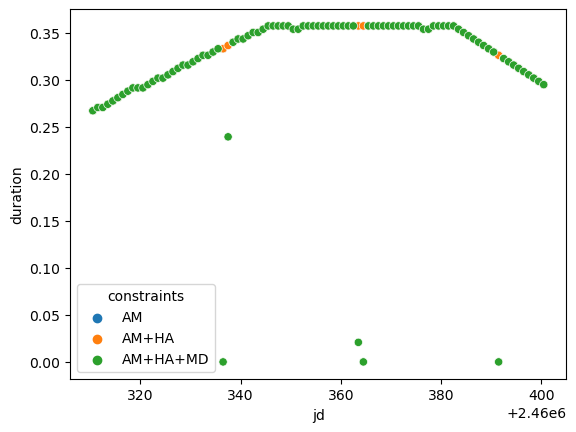

In [32]:
sns.scatterplot(data=obswindows, x='jd', y='duration', hue='constraints');

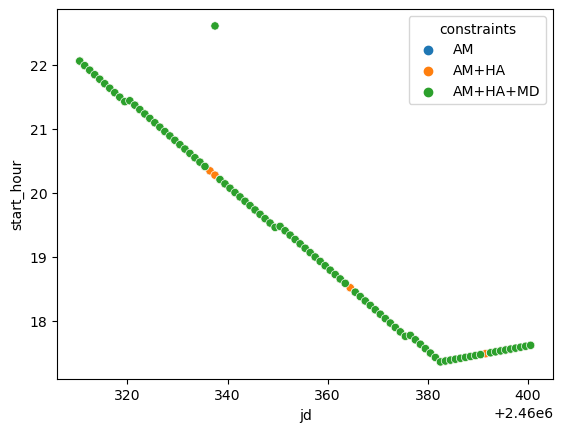

In [33]:
sns.scatterplot(data=obswindows, x='jd', y='start_hour', hue='constraints');

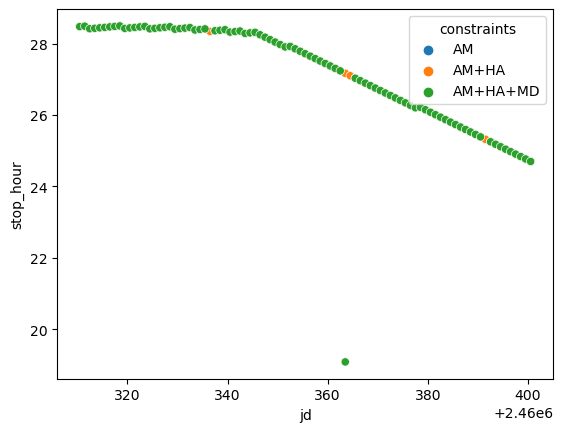

In [34]:
sns.scatterplot(data=obswindows, x='jd', y='stop_hour', hue='constraints');

### Results

The shortened durations (some down to non-observability) over single days are caused by the Moon separation limit.